In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



In [2]:
# ============================================================
# 0️⃣ 경로 설정
# ============================================================
BASE_DIR = Path.cwd().resolve()
DATA_PATH = BASE_DIR.parents[1] / "data" / "raw" / "train.csv"
CLEAN_PATH = BASE_DIR.parents[1] / "data" / "interim" / "train_clean.csv"
MONTHLY_PATH = BASE_DIR.parents[1] / "data" / "processed" / "train_monthly.csv"



In [3]:

# ============================================================
# 1️⃣ 데이터 로드 및 타입 정리
# ============================================================
df = pd.read_csv(DATA_PATH)

df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["seq"] = df["seq"].astype(int)
df["type"] = df["type"].astype(str)
df["hs4"] = df["hs4"].astype(str).str.zfill(4)
df["weight"] = df["weight"].astype(float)
df["quantity"] = df["quantity"].astype(float)
df["value"] = df["value"].astype(int)

print(f"✅ Loaded train.csv: {df.shape}")




✅ Loaded train.csv: (10836, 9)


In [4]:
# ============================================================
# 2️⃣ 결측치 / 이상치 / 중복 처리
# ============================================================
# (1) 결측치 처리
missing_before = df.isna().sum().sum()
df = df.fillna(0)
missing_after = df.isna().sum().sum()
print(f"🧩 결측치 처리 완료: {missing_before} → {missing_after}")

# (2) 음수값 제거
before_rows = len(df)
mask_negative = (df["weight"] < 0) | (df["quantity"] < 0) | (df["value"] < 0)
print(f"⚠️ 음수값 포함 행: {mask_negative.sum()}건")
df = df[~mask_negative]
print(f"✅ 음수 제거 후: {before_rows} → {len(df)} (삭제 {before_rows - len(df)}건)")

# (3) 중복 제거
before_rows = len(df)
dup_count = df.duplicated().sum()
print(f"⚠️ 중복 행 수: {dup_count}")
df = df.drop_duplicates()
print(f"✅ 중복 제거 후: {before_rows} → {len(df)} (삭제 {before_rows - len(df)}건)")




🧩 결측치 처리 완료: 0 → 0
⚠️ 음수값 포함 행: 0건
✅ 음수 제거 후: 10836 → 10836 (삭제 0건)
⚠️ 중복 행 수: 0
✅ 중복 제거 후: 10836 → 10836 (삭제 0건)


In [5]:
# ============================================================
# 3️⃣ 논리 불일치 검증 + 분포 기반 삭제 판단
# ============================================================
print("\n📊 논리 불일치 탐색\n" + "="*50)

case1 = df[(df["value"] == 0) & (df["weight"] > 0)]
case2 = df[(df["weight"] == 0) & (df["value"] > 0)]
inconsistent = pd.concat([case1, case2])
total_inconsistent = len(inconsistent)

print(f"value=0인데 weight>0인 행 수: {len(case1)}")
print(f"weight=0인데 value>0인 행 수: {len(case2)}")
print(f"\n총 불일치 행 수: {total_inconsistent}")

if not inconsistent.empty:
    # 연·월 분포 확인
    ym_summary = (
        inconsistent.groupby(["year", "month"])
        .size()
        .sort_values(ascending=False)
        .head(10)
    )
    print("\n📈 연도·월별 불일치 상위 10개:\n", ym_summary)

    # item 분포 확인
    item_summary = inconsistent["item_id"].value_counts().head(10)
    print("\n🧩 불일치 다발 품목 상위 10개:\n", item_summary)

    # 샘플 출력
    print("\n🔍 불일치 샘플:\n", inconsistent[["item_id", "year", "month", "weight", "value"]].head(10))

    # 삭제 여부 판단
    year_month_unique = inconsistent[["year", "month"]].drop_duplicates().shape[0]
    item_unique = inconsistent["item_id"].nunique()
    print("\n⚖️ 삭제 여부 판단")
    print(f"- 불일치가 발생한 (year, month) 조합 수: {year_month_unique}")
    print(f"- 불일치가 발생한 item_id 수: {item_unique}")

    if year_month_unique > 8 and item_unique >= 30:
        decision = "삭제해도 편향 위험 낮음 → 제거 진행"
    else:
        decision = "특정 구간 집중 가능성 → 삭제 대신 결측 처리 고려"
    print(f"👉 판단 결과: {decision}")
else:
    decision = "삭제 불필요 (불일치 없음)"
    print("🎯 논리 불일치 없음 — 데이터 일관성 양호")

# 실제 제거 수행
if "제거" in decision:
    mask_inconsistent = (
        ((df["value"] == 0) & (df["weight"] > 0)) |
        ((df["weight"] == 0) & (df["value"] > 0))
    )
    before_rows = len(df)
    df = df[~mask_inconsistent].copy()
    print(f"\n✅ 불일치 제거 완료: {before_rows:,} → {len(df):,} (삭제 {before_rows - len(df)}건)")
else:
    print("\n🚫 불일치 행 삭제하지 않음 (EDA 단계 보존)")





📊 논리 불일치 탐색
value=0인데 weight>0인 행 수: 1
weight=0인데 value>0인 행 수: 300

총 불일치 행 수: 301

📈 연도·월별 불일치 상위 10개:
 year  month
2022  4        14
      3        13
      5        12
      9        11
      2        10
      10       10
2023  7         9
2024  2         9
2023  8         8
      2         8
dtype: int64

🧩 불일치 다발 품목 상위 10개:
 item_id
JSLXRQOK    60
SUOYXCHP    46
RCBZUSIM    42
DJBLNPNC    28
YSYHGLQK    17
ZKENOUDA    16
FDXPMYGF    16
WQMVCOEM    12
UIFPPCLR     8
BSRMSVTC     8
Name: count, dtype: int64

🔍 불일치 샘플:
        item_id  year  month  weight  value
9288  WHPUAOID  2025      1     1.0      0
6     RCBZUSIM  2022      1     0.0    459
7     SUOYXCHP  2022      1     0.0    482
81    RCBZUSIM  2022      1     0.0   2287
161   FWUCPMMW  2022      1     0.0     26
203   ZXERAXWP  2022      1     0.0     20
243   FWUCPMMW  2022      2     0.0     24
246   SUOYXCHP  2022      2     0.0    279
247   ZKENOUDA  2022      2     0.0    102
300   FDXPMYGF  2022      2     0.0     

In [6]:
# ============================================================
# 4️⃣ 자동 리포트
# ============================================================
print("\n📊 전처리 품질 리포트\n" + "="*50)

missing = df.isna().sum()
report = pd.DataFrame({
    "MissingCount": missing,
    "MissingRate(%)": (missing / len(df) * 100).round(2)
})
print("중복 행 수:", len(df) - len(df.drop_duplicates()))
print("\n음수 값 수:\n", (df[["weight","quantity","value"]] < 0).sum())

mask = (df["value"] == 0) & (df["weight"] > 0)
print(f"\nvalue=0인데 weight>0인 행 수: {mask.sum()}")

print("\n기초 통계 요약 (상위 5행)\n", df.describe().T.head())
print("\n결측률 요약\n", report)





📊 전처리 품질 리포트
중복 행 수: 0

음수 값 수:
 weight      0
quantity    0
value       0
dtype: int64

value=0인데 weight>0인 행 수: 0

기초 통계 요약 (상위 5행)
             count          mean           std     min     25%     50%  \
year      10535.0  2.023336e+03  1.049461e+00  2022.0  2022.0  2023.0   
month     10535.0  6.110584e+00  3.393392e+00     1.0     3.0     6.0   
seq       10535.0  2.035216e+00  8.129584e-01     1.0     1.0     2.0   
weight    10535.0  1.129796e+06  5.223511e+06     0.0   460.0  7852.0   
quantity  10535.0  8.880450e+04  7.722680e+06     0.0     0.0     0.0   

               75%          max  
year        2024.0       2025.0  
month          9.0         12.0  
seq            3.0          3.0  
weight    168000.0  110491899.0  
quantity       0.0  792598955.0  

결측률 요약
           MissingCount  MissingRate(%)
item_id              0             0.0
year                 0             0.0
month                0             0.0
seq                  0             0.0
type             

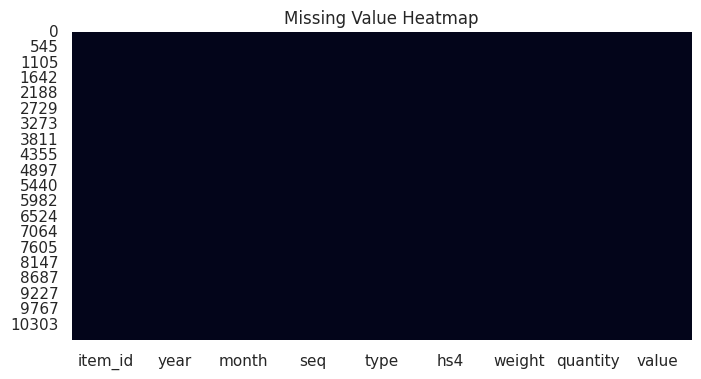

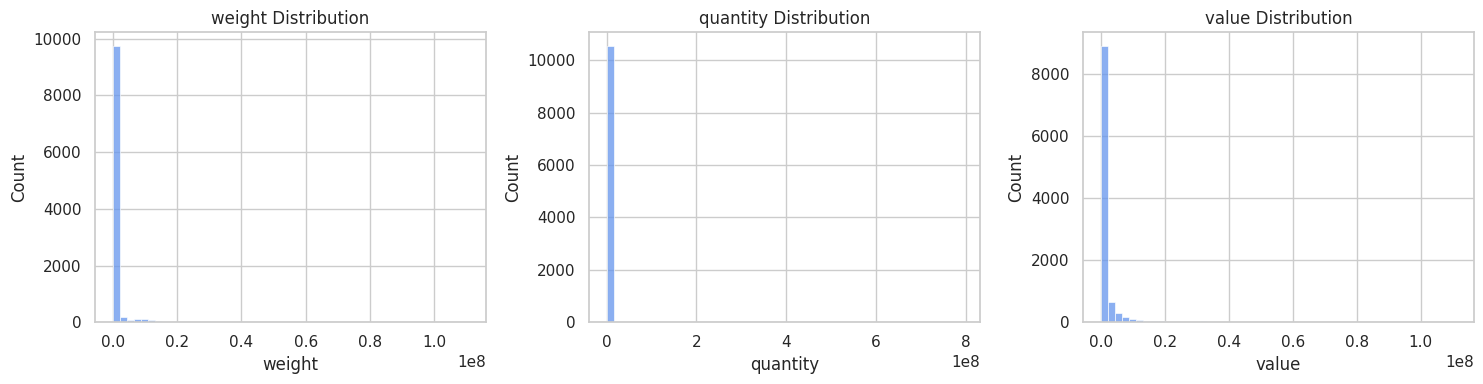

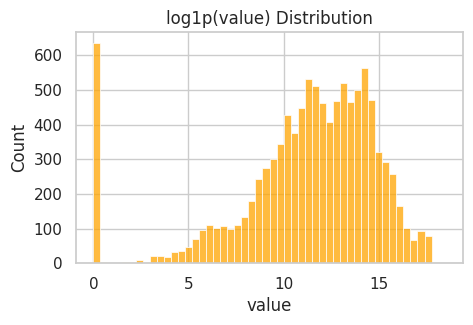

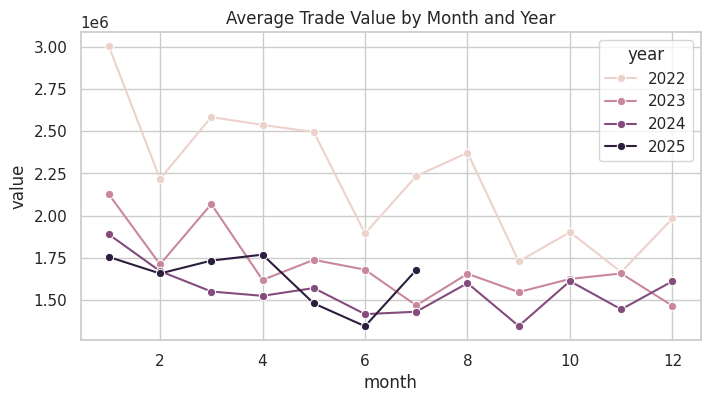

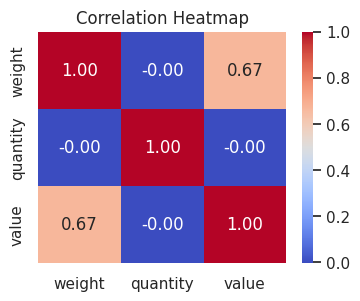

In [7]:
# ============================================================
# 5️⃣ 시각적 점검 (EDA 수준 간략 확인)
# ============================================================
sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 100})

plt.figure(figsize=(8, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

num_cols = ["weight", "quantity", "value"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, c in enumerate(num_cols):
    sns.histplot(df[c], bins=50, ax=axes[i], color="cornflowerblue")
    axes[i].set_title(f"{c} Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(np.log1p(df["value"]), bins=50, color="orange")
plt.title("log1p(value) Distribution")
plt.show()

trend = df.groupby(["year", "month"])["value"].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.lineplot(data=trend, x="month", y="value", hue="year", marker="o")
plt.title("Average Trade Value by Month and Year")
plt.show()

corr = df[["weight", "quantity", "value"]].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()




In [8]:
# ============================================================
# 6️⃣ seq 검증
# ============================================================
print("\n🔍 동일 조합 내 seq 중복 검증\n" + "="*50)
group_cols = ["item_id", "year", "month", "type", "hs4"]
multi_seq = (
    df.groupby(group_cols)["seq"]
      .nunique()
      .reset_index(name="unique_seq_count")
)
multi_seq = multi_seq[multi_seq["unique_seq_count"] > 1]
print(f"⚙️ seq>1인 조합 수: {len(multi_seq):,}")
if len(multi_seq) > 0:
    print("\n예시 5건:\n", multi_seq.head())
    sample_keys = multi_seq[group_cols].head(1).to_dict("records")[0]
    sample = df[
        (df["item_id"] == sample_keys["item_id"]) &
        (df["year"] == sample_keys["year"]) &
        (df["month"] == sample_keys["month"]) &
        (df["type"] == sample_keys["type"]) &
        (df["hs4"] == sample_keys["hs4"])
    ].sort_values("seq")
    print("\n🔍 해당 조합의 실제 원본 데이터:\n", sample)





🔍 동일 조합 내 seq 중복 검증
⚙️ seq>1인 조합 수: 3,556

예시 5건:
     item_id  year  month type   hs4  unique_seq_count
0  AANGBULD  2022      1    1  4810                 2
2  AANGBULD  2022      3    1  4810                 2
3  AANGBULD  2022      5    1  4810                 2
4  AANGBULD  2022      6    1  4810                 3
7  AANGBULD  2023      2    1  4810                 3

🔍 해당 조합의 실제 원본 데이터:
       item_id  year  month  seq type   hs4   weight  quantity  value
122  AANGBULD  2022      1    2    1  4810  17625.0       0.0  14276
204  AANGBULD  2022      1    3    1  4810      0.0       0.0      0


In [9]:
# ============================================================
# 7️⃣ 1차 구조화
# ============================================================
print("\n⚙️ 1차 구조화 진행 중...\n" + "="*50)
monthly = (
    df.groupby(group_cols, as_index=False)
      .agg({
          "value": "sum",
          "weight": "sum",
          "quantity": "sum"
      })
      .rename(columns={
          "value": "total_value",
          "weight": "total_weight",
          "quantity": "total_quantity"
      })
      .sort_values(group_cols)
)
print(f"✅ 구조화 완료: {len(df):,}행 → {len(monthly):,}행")
print("\n기초 통계 (total_value)\n", monthly["total_value"].describe())
dup_check = monthly.groupby(group_cols).size().max()
print(f"✅ 구조화 후 최대 중복 개수: {dup_check}")





⚙️ 1차 구조화 진행 중...
✅ 구조화 완료: 10,535행 → 3,734행

기초 통계 (total_value)
 count    3.734000e+03
mean     5.047678e+06
std      1.502846e+07
min      0.000000e+00
25%      6.362600e+04
50%      3.914360e+05
75%      3.232418e+06
max      1.462168e+08
Name: total_value, dtype: float64
✅ 구조화 후 최대 중복 개수: 1


In [10]:

# ============================================================
# 8️⃣ 저장
# ============================================================
CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)
MONTHLY_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(CLEAN_PATH, index=False)
monthly.to_csv(MONTHLY_PATH, index=False)

print(f"\n💾 Cleaned data saved to: {CLEAN_PATH}")
print(f"💾 Monthly structured data saved to: {MONTHLY_PATH}")



💾 Cleaned data saved to: /data/ephemeral/home/dacon_import_pred/data/interim/train_clean.csv
💾 Monthly structured data saved to: /data/ephemeral/home/dacon_import_pred/data/processed/train_monthly.csv
